# Methods

Starting a new notebook to address many of the thoughts in this comment: https://github.com/ocean-transport/argo-intern/issues/10#issuecomment-1574128413. 

This will likely include work to address:
- different ways to deal with boundaries when filtering
- a closer look into spice anomaly

In [131]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
from importlib import reload
from cmocean import cm as cmo
import xrft

import filt_funcs as ff
import EV_funcs as ef
import plot_funcs as pf
import density_funcs as df
import MLD_funcs as mf
import funcs

In [139]:
reload(ff)
reload(ef)
reload(pf)
reload(df)
reload(mf)
reload(funcs)

<module 'funcs' from '/home.ufs/amf2288/argo-intern/funcs.py'>

In [3]:
float_z = xr.open_dataset('202206_floats/float_ID:(1901700)_ds_z.nc')
float_r = xr.open_dataset('202206_floats/float_ID:(1901700)_ds_rho.nc')

## Boundaries

A few different approaches are possible here, a few of them are noted below:
- filter the whole profile
- filter the whole profile, then mask both boundaries (based on the filter scale)
- filter the whole profile, then mask the upper boundary (based on the mixed layer depth)
- select the profile below the mixed layer, then filter

First up, I'll need to get a handle on mixed layer datasets. Looking at the netcdf file with MLD for every argo profile here: http://mixedlayer.ucsd.edu/. It's a large file though (300+MB) so I have to figure out the best way to upload it here.

In [143]:
float_z = mf.get_MLD(float_z)

In [148]:
filt_100 = ff.get_filt_single(float_z,100,'SPICE')
filt_200 = ff.get_filt_single(float_z,200,'SPICE')
filt_500 = ff.get_filt_single(float_z,500,'SPICE')

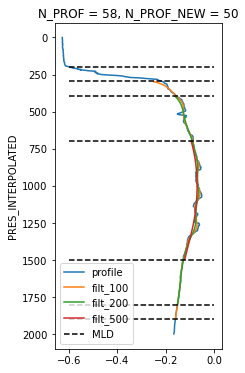

In [177]:
plt.figure(figsize=(3,6))
n=50
float_z.SPICE.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',label='profile')
filt_100.where(filt_100.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED',label='filt_100')
filt_200.where(filt_200.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED',label='filt_200')
filt_500.where(filt_500.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED',label='filt_500')
plt.hlines(float_z.MLD.isel(N_PROF=n),-.6,0,color='k',linestyle='--',label='MLD')
plt.hlines(float_z.MLD.isel(N_PROF=n)+100,-.6,0,color='k',linestyle='--')
plt.hlines(float_z.MLD.isel(N_PROF=n)+200,-.6,0,color='k',linestyle='--')
plt.hlines(float_z.MLD.isel(N_PROF=n)+500,-.6,0,color='k',linestyle='--')
plt.hlines(2000-100,-.6,0,color='k',linestyle='--')
plt.hlines(2000-200,-.6,0,color='k',linestyle='--')
plt.hlines(2000-500,-.6,0,color='k',linestyle='--')
plt.gca().invert_yaxis()
plt.legend()

So I think this is the method we're going with, to filter the whole profile, then mask out the boundary regions as follows:
- top boundary of mask = MLD + filter scale
- bottom boundary of mask = bottom of profile - filter scale

As shown above, everything with the function seems to be working, however using large filter scales removes a very large section of the signal. Is what we have left behind enough data to be usable? For example, 500m throws out over half of the profile -- does that include some valuable parts of the signal?

## Spice Anomaly

Want to compare Dhruv's method (computing spice based on glider reference temperature) to my method (using the defaults in gsw, then calculating the anomaly). Does removing the mean impact the other metrics we are looking at?

xrft.power_spectrum() doesn't work properly when NaNs or missing data is present, so it's really not going to work on the density grid. I think the best thing is to calculate spice and SPICE on the depth grid too? Or maybe make the comparison plot on the depth grid instead of density?

In [81]:
n=0
mean_prof_z  = float_z.SPICE.isel(PRES_INTERPOLATED=n).mean(skipna=True)
SPICE_prof_z = float_z.SPICE.isel(PRES_INTERPOLATED=n) - mean_prof_z

for n in range(1,len(float_z.PRES_INTERPOLATED)):
    mean_prof_z       = float_z.SPICE.isel(PRES_INTERPOLATED=n).mean(skipna=True)
    SPICE_prof_next_z = float_z.SPICE.isel(PRES_INTERPOLATED=n) - mean_prof_z

    SPICE_prof_z = xr.concat([SPICE_prof_z, SPICE_prof_next_z], dim='PRES_INTERPOLATED')

In [101]:
alpha_z = gsw.alpha(float_z.SA, float_z.CT, float_z.PRES_INTERPOLATED)
beta_z = gsw.beta(float_z.SA, float_z.CT, float_z.PRES_INTERPOLATED)

dCT_z = float_z.CT - float_z.CT.mean('N_PROF')
dSA_z = float_z.SA - float_z.SA.mean('N_PROF')

float_z['spice']= 1000*alpha_z*dCT_z + 1000*beta_z*dSA_z


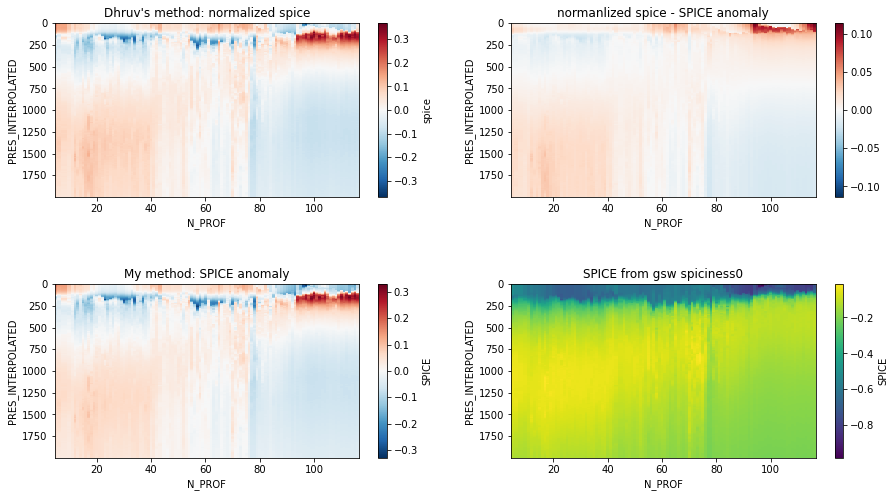

In [103]:
plt.figure(figsize=(15,8))

plt.subplot(2,2,1)
float_z.spice.plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title("Dhruv's method: normalized spice")

plt.subplot(2,2,2)
(float_z.spice - SPICE_prof_z).plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title("normanlized spice - SPICE anomaly")

plt.subplot(2,2,3)
SPICE_prof_z.plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title("My method: SPICE anomaly")

plt.subplot(2,2,4)
float_z.SPICE.plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title("SPICE from gsw spiciness0")

plt.subplots_adjust(hspace=0.5)

In [111]:
spice_spec_z = xrft.power_spectrum(float_z.spice,dim='PRES_INTERPOLATED', window='hamming')
SPICE_spec_z = xrft.power_spectrum(spice_prof_z ,dim='PRES_INTERPOLATED', window='hamming')

In [112]:
spice_spec_mean_z = xrft.power_spectrum(float_z.spice - float_z.spice.mean('N_PROF'),dim='PRES_INTERPOLATED', window='hamming')
SPICE_spec_mean_z = xrft.power_spectrum(spice_prof_z  - spice_prof_z .mean('N_PROF'),dim='PRES_INTERPOLATED', window='hamming')

In [ ]:
stick with gsw method

In [113]:
m = SPICE_spec_z.freq_PRES_INTERPOLATED

Text(0.5, 1.0, 'plot 1 - plot 2')

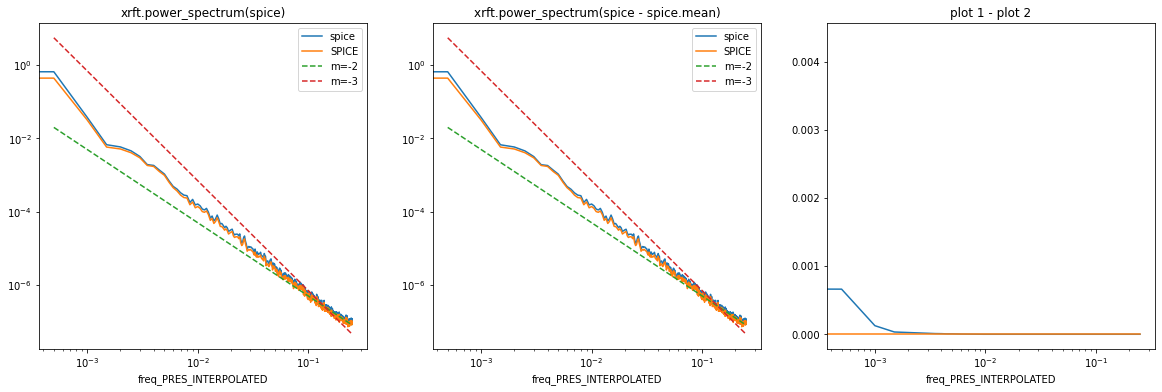

In [117]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
spice_spec_z.mean('N_PROF').plot(label='spice')
SPICE_spec_z.mean('N_PROF').plot(label='SPICE')

kz = spice_spec_z.freq_PRES_INTERPOLATED
plt.plot(kz, 5e-9*kz**(-2), '--', label='m=-2')
plt.plot(kz, 7e-10*kz**(-3), '--', label='m=-3')

plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-8, 1e1)
plt.legend()
plt.title('xrft.power_spectrum(spice)')

plt.subplot(1,3,2)
spice_spec_mean_z.mean('N_PROF').plot(label='spice')
SPICE_spec_mean_z.mean('N_PROF').plot(label='SPICE')

kz = spice_spec_mean_z.freq_PRES_INTERPOLATED
plt.plot(kz, 5e-9*kz**(-2), '--', label='m=-2')
plt.plot(kz, 7e-10*kz**(-3), '--', label='m=-3')

#plt.ylim(1e-8, 1e1)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('xrft.power_spectrum(spice - spice.mean)')


plt.subplot(1,3,3)
(spice_spec_z - spice_spec_mean_z).mean('N_PROF').plot(label='spice')
(SPICE_spec_z - SPICE_spec_mean_z).mean('N_PROF').plot(label='SPICE')

plt.xscale('log')
plt.title('plot 1 - plot 2')

This compares the method of taking the power_spectrum of just spice to the mean spice subtracted from spice. It seems like the only effect this has is in the larger filter scale side of the spectrum and only for the method with a reference temperature gradient. This probably makes sense because in my method, the large scale signals have already been removed, so this has less of an effect. I think the next step is to see if (how?) this effects individual lines, not just the .mean('N_PROF') which is plotted here.

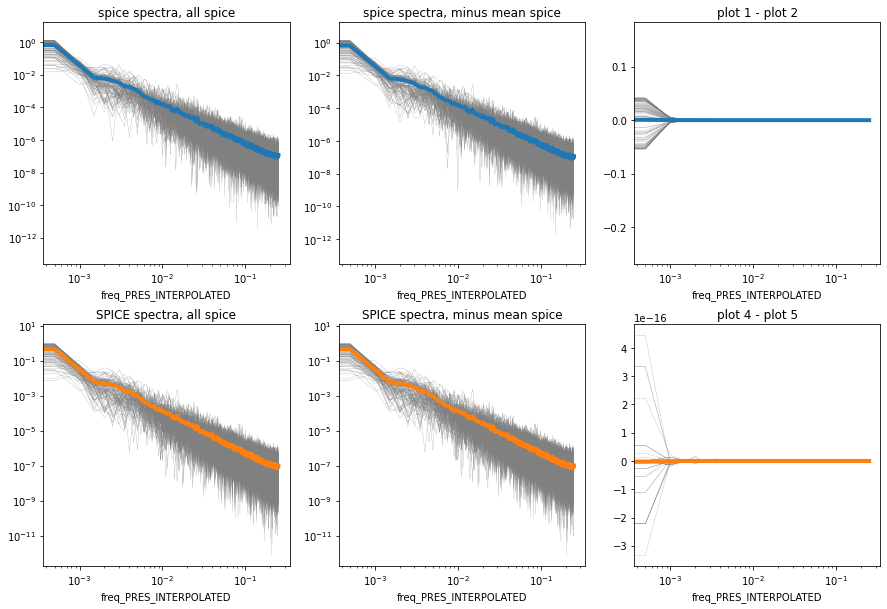

In [124]:
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
for n in range(0, len(spice_spec_z.N_PROF)):
    spice_spec_z.isel(N_PROF=n).plot(color='gray',linewidth=0.2)
spice_spec_z.mean('N_PROF').plot(color='tab:blue',linewidth=4)
plt.xscale('log')
plt.yscale('log')
plt.title('spice spectra, all spice')

plt.subplot(2,3,2)
for n in range(0, len(spice_spec_mean_z.N_PROF)):
    spice_spec_mean_z.isel(N_PROF=n).plot(color='gray',linewidth=0.2)
spice_spec_mean_z.mean('N_PROF').plot(color='tab:blue',linewidth=4)
plt.xscale('log')
plt.yscale('log')
plt.title('spice spectra, minus mean spice')

plt.subplot(2,3,3)
for n in range(0, len(spice_spec_z.N_PROF)):
    (spice_spec_z.isel(N_PROF=n) - spice_spec_mean_z.isel(N_PROF=n)).plot(color='gray',linewidth=0.2)
(spice_spec_z - spice_spec_mean_z).mean('N_PROF').plot(color='tab:blue',linewidth=4)
plt.xscale('log')
plt.title('plot 1 - plot 2')

plt.subplot(2,3,4)
for i in range(0, len(SPICE_spec_z.N_PROF)):
    SPICE_spec_z.isel(N_PROF=i).plot(color='gray',linewidth=0.2)
SPICE_spec_z.mean('N_PROF').plot(color='tab:orange',linewidth=4)
plt.xscale('log')
plt.yscale('log')
plt.title('SPICE spectra, all spice')

plt.subplot(2,3,5)
for i in range(0, len(SPICE_spec_mean_z.N_PROF)):
    SPICE_spec_mean_z.isel(N_PROF=i).plot(color='gray',linewidth=0.2)
SPICE_spec_mean_z.mean('N_PROF').plot(color='tab:orange',linewidth=4)
plt.xscale('log')
plt.yscale('log')
plt.title('SPICE spectra, minus mean spice')

plt.subplot(2,3,6)
for n in range(0, len(spice_spec_z.N_PROF)):
    (SPICE_spec_z.isel(N_PROF=n) - SPICE_spec_mean_z.isel(N_PROF=n)).plot(color='gray',linewidth=0.2)
(SPICE_spec_z - SPICE_spec_mean_z).mean('N_PROF').plot(color='tab:orange',linewidth=4)
plt.xscale('log')

plt.title('plot 4 - plot 5')

plt.subplots_adjust(hspace=0.25)

---
---
___

In [79]:
n=0
mean_prof_r  = float_r.SPICE.isel(rho_grid=n).mean(skipna=True)
SPICE_prof_r = float_r.SPICE.isel(rho_grid=n) - mean_prof_r

for n in range(1,len(float_r.rho_grid)):
    mean_prof_r       = float_r.SPICE.isel(rho_grid=n).mean(skipna=True)
    SPICE_prof_next_r = float_r.SPICE.isel(rho_grid=n) - mean_prof_r

    SPICE_prof_r = xr.concat([SPICE_prof_r, SPICE_prof_next_r], dim='rho_grid')

In [16]:
alpha_r = gsw.alpha(float_r.SA, float_r.CT, float_r.PRES_INTERPOLATED)

dCT_r = float_r.CT - float_r.CT.mean('N_PROF_NEW')
float_r['spice']= 2*1000*alpha_r*dCT_r

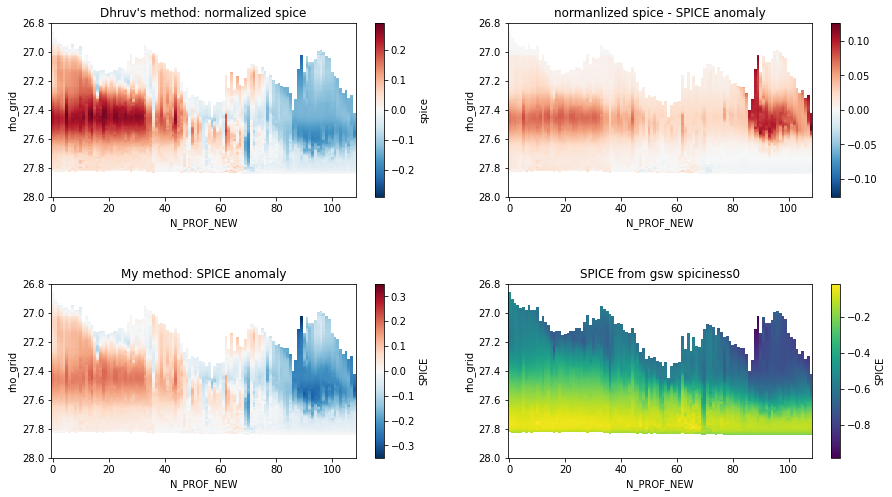

In [80]:
plt.figure(figsize=(15,8))

plt.subplot(2,2,1)
float_r.spice.plot()
plt.gca().invert_yaxis()
plt.title("Dhruv's method: normalized spice")

plt.subplot(2,2,2)
(float_r.spice - SPICE_prof_r).plot()
plt.gca().invert_yaxis()
plt.title("normanlized spice - SPICE anomaly")

plt.subplot(2,2,3)
SPICE_prof_r.plot()
plt.gca().invert_yaxis()
plt.title("My method: SPICE anomaly")

plt.subplot(2,2,4)
float_r.SPICE.plot()
plt.gca().invert_yaxis()
plt.title("SPICE from gsw spiciness0")

plt.subplots_adjust(hspace=0.5)